In [1]:
import seaborn as sns
%pylab inline
%load_ext hymagic
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


/home/tom/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import utils as ut
from utils import lNot, lAnd, lOr, lXor
from math import copysign

In [3]:
%%hylang
(import [glob [glob]])
(setv f05 (glob "dat/highres/*inc005.dat"))
(setv f60 (glob "dat/highres/*inc060.dat"))
(setv f85 (glob "dat/highres/*inc085.dat"))

In [4]:
X00=([[int (x.split('_')[3]),loadtxt(x)] for x in f05])
X60=([[int (x.split('_')[3]),loadtxt(x)] for x in f60])
X90=([[int (x.split('_')[3]),loadtxt(x)] for x in f85])

In [5]:
for i in xrange(len(X00)):
    X00[i][1][:,0]/=1e4
    X00[i][1][:,1][X00[i][1][:,1]<=0]=1e-99 #ensure no 0 values, they mess up log scaling and averages
X00.sort(key=lambda a: a[0])
for i in xrange(len(X60)):
    X60[i][1][:,0]/=1e4
    X60[i][1][:,1][X60[i][1][:,1]<=0]=1e-99
X60.sort(key=lambda a: a[0])
for i in xrange(len(X90)):
    X90[i][1][:,0]/=1e4
    X90[i][1][:,1][X90[i][1][:,1]<=0]=1e-99
X90.sort(key=lambda a: a[0])

figures below:
* *top* total luminosity as a function of time, black points obey RMS cuts, coloured ones do not (r,g and b correspond to first 3 cuts)
* *left* 21µm/14µm (red), 14µm/8µm (blue), 8µm/2.2µm (green) and 2.2µm/1.25µm (black) ratios as functions of time  
* *right* 21µm/14µm (red), 14µm/8µm (blue), 8µm/2.2µm (green) and 2.2µm/1.25µm (black) ratios plotted against total luminocity  
* *bottom* colour colour plots colours show early (cold) to late (hot):  
top left  21µm/14µm v 14µm/8µm; top right 21µm/8µm v 8µm/2.2µm  
botom left 14µm/8µm v 2.2µm/1.25µm; bottom right 8µm/2.2µm v 2.2µm/1.25µm

for 0 60 and 90 degree viewing angles 

In [6]:
from scipy.ndimage.filters import gaussian_filter1d as gfilter
S=ut.FWHM2sigma(3.0) #smoothing sigma to use

In [7]:
from scipy.interpolate import UnivariateSpline as uspline
a_rsr=loadtxt('msx_rsr_a.tbl')#relative spectral response tables for msx and 2mass
a_rsr=uspline(a_rsr[:,0], a_rsr[:,1],k=1,s=0)#1st order spline forced through all points (i.e. does lerping)
c_rsr=loadtxt('msx_rsr_c.tbl')
c_rsr=uspline(c_rsr[:,0], c_rsr[:,1],k=1,s=0)
d_rsr=loadtxt('msx_rsr_d.tbl')
d_rsr=uspline(d_rsr[:,0], d_rsr[:,1],k=1,s=0)
e_rsr=loadtxt('msx_rsr_e.tbl')
e_rsr=uspline(e_rsr[:,0], e_rsr[:,1],k=1,s=0)
j_rsr=loadtxt('2mass_rsr_J.dat')
j_rsr=uspline(j_rsr[:,0], j_rsr[:,1],k=1,s=0)
k_rsr=loadtxt('2mass_rsr_K.dat')
k_rsr=uspline(k_rsr[:,0], k_rsr[:,1],k=1,s=0)

#square widths - fractional
a_width=3.4/8.3
c_width=1.7/12.1
d_width=2.2/14.7
e_width=6.2/21.3
j_width=0.25/1.25
k_width=0.35/2.2


In [16]:
def returnColours (X, tmin, tmax):
    bol,c21,c14,c8,c3,c2,c1,time=[],[],[],[],[],[],[],[]
    for x in [np.maximum(0,e_rsr(y[:,0]))*y[:,1] for t,y in X if t>=tmin and t<=tmax]:
        c21.append(x.sum()/e_width)#E 21.3 width 6.2
    for x in [np.maximum(0,d_rsr(y[:,0]))*y[:,1] for t,y in X if t>=tmin and t<=tmax]:
        c14.append(x.sum()/d_width)#D 14.7 width 2.2
    #for x in [10**gfilter(log10(y[:,1]), sigma=ut.FWHM2sigma(4.0)) for t,y in X if t>=tmin and t<=tmax]:
    #    c12.append(x[104])#C 12.1 width 1.7 #old method, not being used
    for x in [np.maximum(0,a_rsr(y[:,0]))*y[:,1] for t,y in X if t>=tmin and t<=tmax]:
        c8.append (x.sum()/a_width) #A 8.3 width 3.4
    for x in [np.maximum(0,k_rsr(y[:,0]))*y[:,1] for t,y in X if t>=tmin and t<=tmax]:
        c2.append (x.sum()/k_width) #j band
    for x in [np.maximum(0,j_rsr(y[:,0]))*y[:,1] for t,y in X if t>=tmin and t<=tmax]:
        c1.append (x.sum()/j_width) #k band
    
    return [array(lis) for lis in c21,c14,c8,c2,c1]

returnColors=ut.memoize(returnColours)

In [17]:
def SEDplots (X, titleStr='', sig=S, tmin=70, tmax=+inf):
    ut.FWHM2sigma
    #tmp=[(t,10**gfilter(log10(x[:,1]), sigma=sig)) for t,x in X if t>=70]

    time,bol=[],[]
    for t,x in [(a,b) for a,b in X if a>=tmin and a<=tmax]:
        bol.append(x[:,1].sum())
        time.append(t)
    time=array(time);bol=array(bol)

    c21,c14,c8,c2,c1=returnColours(X,tmin,tmax)
    
    cuts= lAnd(c8<=c14, c14<=c21), (c21/c8)>2, (c8/c2)>5, lOr((c2/c1)>2, lAnd(c2<1e-50,c1<1e-50)) #c2/c1 >2 is relaxed for if we dont have significant emission at these short wavelengths
    #print map(lambda x: x.shape, [bol,c21,c8,c2,c1,time,cuts[0]])
#    print zip(bol,time)
    semilogy(time[reduce(lAnd, cuts)],bol[reduce(lAnd, cuts)],'k.', markersize=5.0)
    semilogy(time[lAnd(lAnd(cuts[0],cuts[1]), lNot(cuts[2]))],bol[lAnd(lAnd(cuts[0],cuts[1]), lNot(cuts[2]))],'b.', markersize=5.0)
    semilogy(time[lAnd(lAnd(cuts[2],cuts[0]), lNot(cuts[1]))],bol[lAnd(lAnd(cuts[2],cuts[0]), lNot(cuts[1]))],'g.', markersize=5.0)
    semilogy(time[lAnd(lAnd(cuts[2],cuts[1]), lNot(cuts[0]))],bol[lAnd(lAnd(cuts[2],cuts[1]), lNot(cuts[0]))],'r.', markersize=5.0)
    semilogy(time[lAnd(lNot(lOr(cuts[0],cuts[1])), cuts[2])],bol[lAnd(lNot(lOr(cuts[0],cuts[1])), cuts[2])],'y.', markersize=5.0)
    semilogy(time[lAnd(lNot(lOr(cuts[2],cuts[0])), cuts[1])],bol[lAnd(lNot(lOr(cuts[2],cuts[0])), cuts[1])],'m.', markersize=5.0)
    semilogy(time[lAnd(lNot(lOr(cuts[2],cuts[1])), cuts[0])],bol[lAnd(lNot(lOr(cuts[2],cuts[1])), cuts[0])],'c.', markersize=5.0)
    semilogy(time[reduce(lAnd, lNot(cuts))],bol[reduce(lAnd, lNot(cuts))],'w*')
#    gca().set_ylim(bottom=1e-30)
    title(titleStr)
    figure()

    subplot(221)
    semilogy(time,c21/c14,'r') 
    semilogy(time,c14/c8,'b')
    legend(['F21/F14', 'F14/F8'], numpoints=3, loc='best')
    gca().set_ylim(0.1,1000)

    subplot(222)
    loglog(bol,c21/c14,'r')
    loglog(bol,c14/c8,'b')
    
    gca().set_ylim(0.1,1000)

    subplot(223)
    semilogy(time,c8/c2,'g')
    semilogy(time,c21/c8, 'k')
    legend(['F8/Fk','F21/F8'], numpoints=3, loc='best')
    gca().set_ylim(1e-1,1e10)
    
    subplot(224)
    loglog(bol,c8/c2,'g')
    loglog(bol,c21/c8, 'k')
    gca().set_ylim(1e-1,1e10)

    fig=figure()
    col=(time-time.min())
    cl=col*100/col.max()
    ax=fig.add_subplot(221)
    scatter(log10(c21/c14),log10(c14/c8), c=cl, cmap=cm.gist_heat, linewidths=zeros_like(time) )
    ax.set_xlabel(r'F21/F14')
    ax.set_ylabel(r'F14/F8')
    gca().set_ylim(-1,10)
    gca().set_xlim(-1,10)
    ax=fig.add_subplot(222)
    scatter(log10(c21/c8),log10(c8/c2), c=cl, cmap=cm.gist_heat, linewidths=zeros_like(time) )
    ax.set_xlabel(r'F21/F8')
    ax.set_ylabel(r'F8/Fk')
    gca().set_ylim(-1,10)
    gca().set_xlim(-1,10)
    ax=fig.add_subplot(223)
    scatter(log10(c14/c8),log10(c2/c1), c=cl, cmap=cm.gist_heat, linewidths=zeros_like(time) )
    ax.set_xlabel(r'F14/F8')
    ax.set_ylabel(r'Fk/Fj')
    gca().set_ylim(-1,10)
    gca().set_xlim(-1,10)
    ax=fig.add_subplot(224)
    scatter(log10(c8/c2),log10(c2/c1), c=cl, cmap=cm.gist_heat, linewidths=zeros_like(time) )
    ax.set_xlabel(r'F8/Fk')
    ax.set_ylabel(r'Fk/Fj')
    gca().set_ylim(-1,10)
    gca().set_xlim(-1,10)

    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.5)

    figure()
    d={t:x for t,x in [(a,10**gfilter(log10(b[:,1]), sigma=sig)) for a,b in X if a>=tmin]}
    leg=[]
    for i in range(tmin,281,30):
        try:
            x=10**((log10(d[i])+log10(d[i+1])+log10(d[i+2]))/3)
        except KeyError:
            x=d[i]
        x[x<=0]=1e-99
        loglog(X00[0][1][:,0],x)
        leg.append(i)
    gca().set_ylim(bottom=1e-25)
    legend(leg, loc='best')

    plt.tight_layout()

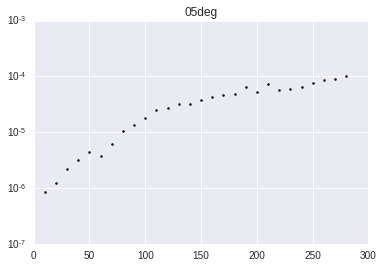

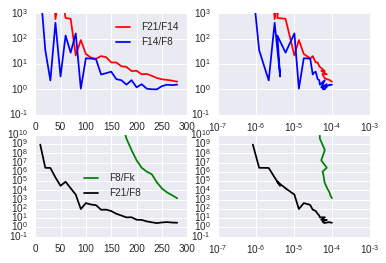

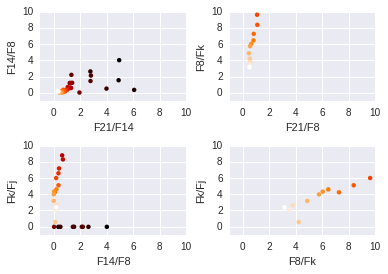

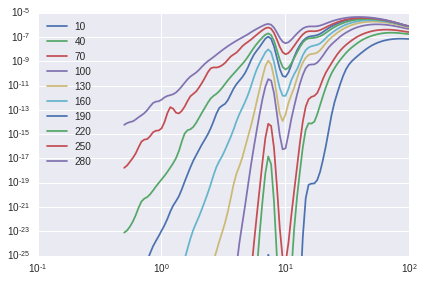

In [23]:
SEDplots(X00,'05deg', tmin=10)

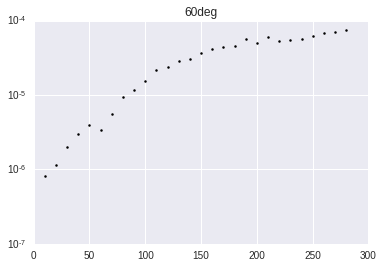

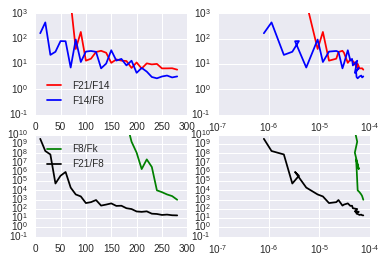

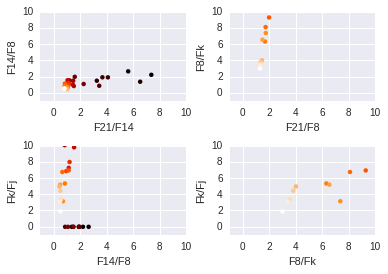

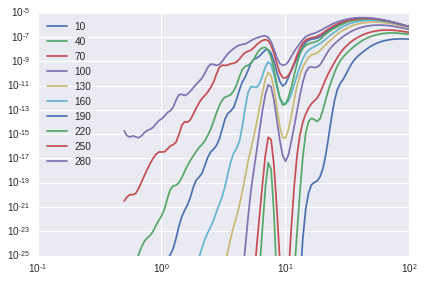

In [19]:
SEDplots(X60,'60deg', tmin=10)

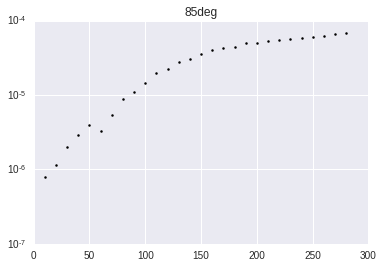

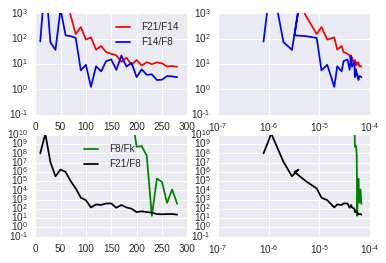

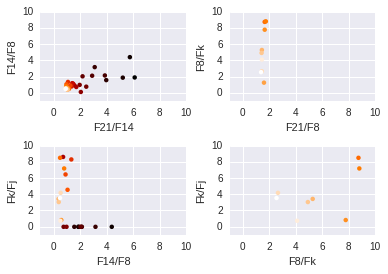

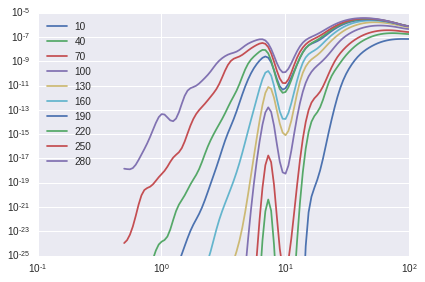

In [20]:
SEDplots(X90,'85deg',sig=1.5*S, tmin=10)

0 and 60 degree models both show clear reddening in both waveband ratios, both in time and as a function of luminocity. The edge on 90 model is less clear however, the 21/8 ratio shows some reddening with time but is much less clear with luminocity. For the 14/4.6 ratio there is little trend at all.

Gauusian smoothing with sigma of 1, 1 and 2 bins are used in these plots to compensate for insuficient photon sampling and improve signal to noise 

In [ ]:
def specInd (x):
    "calculate the average spectral index d log(F lambda) /d log(lambda) in the range of 10-100µm"
    return gradient( log10( x[99:151]), 0.0201).mean()

In [ ]:
def smooth (d,i):
    "smooths spectra by averaging it with the previous and next spectra in the time series if possible,"
    try:
        assert i!=0 and i!=-1
        out=log10(d[i-1][:,1])+log10(d[i][:,1])+log10(d[i+1][:,1])
        out=10**(out/3)
    except (AssertionError, KeyError):
        pass
    else:
        return out
    
    try:
        out=log10(d[i][:,1])+log10(d[i+1][:,1])
        out=10**(out/2)
    except KeyError:
        pass
    else:
        return out
    
    try:
        out=log10(d[i][:,1])+log10(d[i-1][:,1])
        out=10**(out/2)
    except KeyError:
        pass
    else:
        return out
    
    return d[i][:,1]

In [ ]:
d={t:x for t,x in X00}
for k in d:
  if k>90:
    ind=specInd(d[k][:,1])
    plot(k,ind,'b,')
    ind=specInd(10**gfilter(log10(d[k][:,1]), sigma=1))
    plot(k,ind,'r,')
    gca().set_ylim(-1,20)
pass

In [ ]:
d={t:x for t,x in X60}
for k in d:
  if k>90:
    ind=specInd(d[k][:,1])
    plot(k,ind,'b,')
    ind=specInd(10**gfilter(log10(d[k][:,1]), sigma=1))
    plot(k,ind,'r,')
    gca().set_ylim(-1,20)
pass

In [ ]:
d={t:x for t,x in X90}
for k in d:
  if k>90:
    ind=specInd(d[k][:,1])
    plot(k,ind,'b,')
    ind=specInd(10**gfilter(log10(d[k][:,1]), sigma=2))
    plot(k,ind,'r,')
    gca().set_ylim(-1,20)
pass

The average spectral index in the region of 10-100µm can been seen to be decreasing with time.  
Putting the output through a small gaussian convolution before calculating the spectral index reduces the impact of noise of the calculation

In [ ]:
nd=loadtxt('dat/sed_IRmm_amin0.15micron0200_inc060.dat')
nd[:,0]/=1e4
nd[:,1][nd[:,1]<1e-99]=1e-99

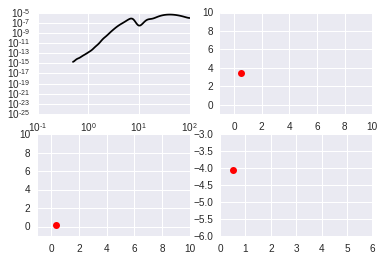

In [157]:
from matplotlib.lines import Line2D

d={t:x for t,x in [(a,10**gfilter(log10(b[:,1]), sigma=2)) for a,b in X00 if a>=0]}
ts=sorted(d.keys())

time,bol=[],[]
for t,x in [(a,b) for a,b in X00 if a>=0 and a<=+inf]:
        bol.append(x[:,1].sum())
        time.append(t)
time=array(time);bol=array(bol)

c21,c14,c8,c2,c1=returnColours(X00,0,+inf)
            
class SubplotAnimation(animation.TimedAnimation):
    def __init__(self):
        fig,axes = subplots(2,2)
        self.line1 = Line2D([], [], color='black')
        axes[0,0].add_line(self.line1)
        axes[0,0].loglog()
        axes[0,0].set_ylim(1e-25,1e-5)
        axes[0,0].set_xlim(1e-1,1e2)
        self.line2 = Line2D([], [], color='red', marker="o")
        axes[1,0].add_line(self.line2)
        axes[1,0].set_ylim(-1,10)
        axes[1,0].set_xlim(-1,10)
        self.line3 = Line2D([], [], color='red', marker="o")
        axes[0,1].add_line(self.line3)
        axes[0,1].set_ylim(-1,10)
        axes[0,1].set_xlim(-1,10)
        self.line4 = Line2D([], [], color='red', marker="o")
        axes[1,1].add_line(self.line4)
        axes[1,1].set_ylim(-6,-3)
        axes[1,1].set_xlim(0,6)
        animation.TimedAnimation.__init__(self, fig, interval=300, blit=True)

    def _draw_frame(self, i):
        self.line1.set_data(X00[i][1][:,0],d[i*10])
        self.line2.set_data(log10(c21[i]/c14[i]),log10(c14[i]/c8[i]))
        self.line3.set_data(log10(c21[i]/c8[i]),log10(c8[i]/c2[i]))
        self.line4.set_data(log10(c21[i]/c8[i]),log10(bol[i]))
        self._drawn_artists = [self.line1]

    def new_frame_seq(self):
        return iter(range(0,28))

    def _init_draw(self):
        lines = [self.line1]
        for l in lines:
            l.set_data([], [])

ani = SubplotAnimation()
ani.save('test_sub.mp4')
plt.show()

In [154]:
c21[8]/c8[8], log10(bol[26])

(3504.143272392957, -4.0632615766458944)